In [17]:
from IPython.display import Markdown, display
display(Markdown(open("./SM_header.md", "r").read()))

Copyright © 2025 Université Paris Cité

Author: [Guillaume Rousseau](https://www.linkedin.com/in/grouss/), Department of Physics, Paris, France (email: guillaume.rousseau@u-paris.fr)

This archive contains the supplemental materials and replication package associated with the preprint, "*Temporal and topological partitioning in real-world growing networks for scale-free properties study*", available on [arXiv](https://arxiv.org/abs/2501.10145) and [ssrn](http://ssrn.com/abstract=5191689).

The current version of the Python scripts and associated resources is available on the [author's GitHub page](https://github.com/grouss/growing-network-study).

This work is currently licensed under the [Creative Commons CC BY-NC-SA 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0).

To give appropriate credit and cite this work ([BibTeX entry](./rousseau2025temporal)):
Rousseau, G. (2025). *Temporal and topological partitioning in real-world growing networks for scale-free properties study* [Preprint]. arXiv:2501.10145. https://arxiv.org/abs/2501.10145; also available on SSRN: http://ssrn.com/abstract=5191689

 
# A) Replication Package

[Open the corresponding Replication Package notebook](./Replication_Package.ipynb)

# B) QuickStart Guide

[Open the corresponding QuickStart Guide notebook](./SM00_QuickStart.ipynb)

# C) Table of Contents

- 1. [Function Definitions](./SM01_Functions.ipynb)
- 2. [Dataset Import](./SM02_DatasetImport.ipynb)
- 3. [Building the Transposed Graph](./SM03_BuildingTransposedGraph.ipynb)
- 4. [Temporal Information Quality and Summary Statistics](./SM04_TemporalInformationMainStats.ipynb)
- 5. [Growth Relationship Between Nodes and Edges](./SM05_GrowingRules.ipynb)
- 6. [Topological Partitioning($RV$ Nodes)](./SM06_TopologicalPartitioning.ipynb)
- 7. [In-Degree and Out-Degree Distributions Over Time](./SM07_DegreeDistributionOverTime.ipynb)
- 8. [Distribution Tail Analysis](./SM08_DistributionTailAnalysis.ipynb)
- 9. [Temporal Partitioning](./SM09_TemporalPartitioning.ipynb)
- 10. [Derived $O-(RV/RL)-O$ Graph Construction](./SM10_DerivedGrowingNetwork.ipynb)
- 11. Building the $TSL$ Partitioning (not provided yet)
- 12. Barabási–Albert Model Use Case (not provided yet)


**NB :** As of 2025/05/07, only the QuickStart guide, the replication package, SM01 to SM10 are available. The Python scripts are also provided under `local_utils` directory, but they are not in their final form and should be considered an alpha release. The graphs used in the study are available in a distinct Zenodo Deposit 10.5281/zenodo.15260640 ($\sim50$ Go), including the main dataset $O/RV/RL-O/RV/RL$ (2+ billions of nodes, $\sim4$ billions of edges), and two derived $O-(RV/RL)-O$ graphs ($\sim150$ millions nodes and edges). 

In [5]:
%load_ext autoreload
%autoreload 2

import importlib,sys,local_utils
from local_utils import *

print("___ Import data from graphpath=",config.graphpath)
print("___ Export data to exportpath=",config.exportpath)   

DisplayCopyrightInfo()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
___ Import data from graphpath= ./ImportData/
___ Export data to exportpath= ./ExportData/
--------------------------------------------------------------------------------
Copyright 2025 Université Paris Cité, France 
Author: Guillaume Rousseau, Physics Department, Paris, France 

(https://www.linkedin.com/in/grouss/)

This archive contains the supplemental materials and replication package associated with the preprint available on :
- arXiv (https://arxiv.org/abs/2501.10145)
- SSRN  (http://ssrn.com/abstract=5191689

Current version of python scripts and associated ressources are available on author's github page
(https://github.com/grouss/growing-network-study)

This work is currently licensed under CC BY-NC-SA 4.0
(https://creativecommons.org/licenses/by-nc-sa/4.0)
--------------------------------------------------------------------------------



---

## 9. Temporal Partitioning

## a) Accounting for Origin Nodes

The distribution of incoming degrees for $RV>RV$ edges is determined at the level of the subgraph restricted to $RV$ nodes and the edges connecting them. This approach, however, does not account for potential correlations between this marginal distribution and the in-degrees of certain $RV$ nodes with respect to $origin$ ($O$) or $release$ ($RL$) nodes. It also disregards the fact that the graph is directed, implying that only specific $(RV, RL)$ nodes are reachable from a given origin node.

For example, in the case of the main repository of the `composer` project (origin node with `index=59,554,119` in the node table), it can be observed that the revision node (`index=264,840,951`) with the highest number of incoming $RV>RV$ edges (approximately 700,000) must be connected to a large number of revisions from other repositories, given that the repository itself contains only slightly more than 10,000 revisions and releases.


In [5]:
nodes,edges,nodesad,d,Nnodes,Nedges=LoadAllArray()   

In [6]:
index_revision=264840951
index_origin=59554119
url="https://github.com/composer/composer"
name="composer"
knownindexset=GetNodesDescedants(index_origin,nodes,edges)
knownindexset=np.array(list(knownindexset))
Nrevision=np.sum(knownindexset>=d["RVindexMin"])
Nrelease=np.sum(knownindexset>=d["RLindexMin"])-Nrevision
print(f'{Nrevision:10,} revisions are known in Composer git repository {url}')
print(f'{Nrelease:10,} releases  are known in Composer git repository {url}')
if index_revision in knownindexset:
    print()
    print(f'The revision node of index {index_revision:,} belong to Composer git repository {url}')
print(f'The node of index {index_revision:,} has {nodes[index_revision+1]-nodes[index_revision]:10,} outgoing edges')
print(f'The node of index {index_revision:,} has {np.sum(edges==index_revision):10,} ingoing  edges')

    10,507 revisions are known in Composer git repository https://github.com/composer/composer
        93 releases  are known in Composer git repository https://github.com/composer/composer

The revision node of index 264,840,951 belong to Composer git repository https://github.com/composer/composer
The node of index 264,840,951 has          2 outgoing edges
The node of index 264,840,951 has    693,439 ingoing  edges


## b) In the scope of this study

We can display the same metrics for these two projects while taking into account the distinction between `inner` and `outer` edges. An edge is considered `inner` if both the source and target nodes are reachable by traversing the derived graph starting from the origin node. Conversely, an edge is classified as `outer` if the source node is not reachable from the origin node.


In [8]:
Rebuild=False
Fsave=False

In [9]:
# build metrics for two particular project
if Rebuild:
    for index_origin,url,name in [
        (59554119,"https://github.com/composer/composer","composer"),
        (13070455,'https://github.com/torvalds/linux',"linux"),
]:
        inputdict=GetInnerOriginRVRVDegreeStat(index_origin,nodes,edges,nodesad,Nnodes,Nedges,name,url,Threshold=d["RVindexMin"])
        if Fsave:
            pickle.dump(inputdict,open(exportpath+name+"_degree_dt_20240930.pkl","wb"))

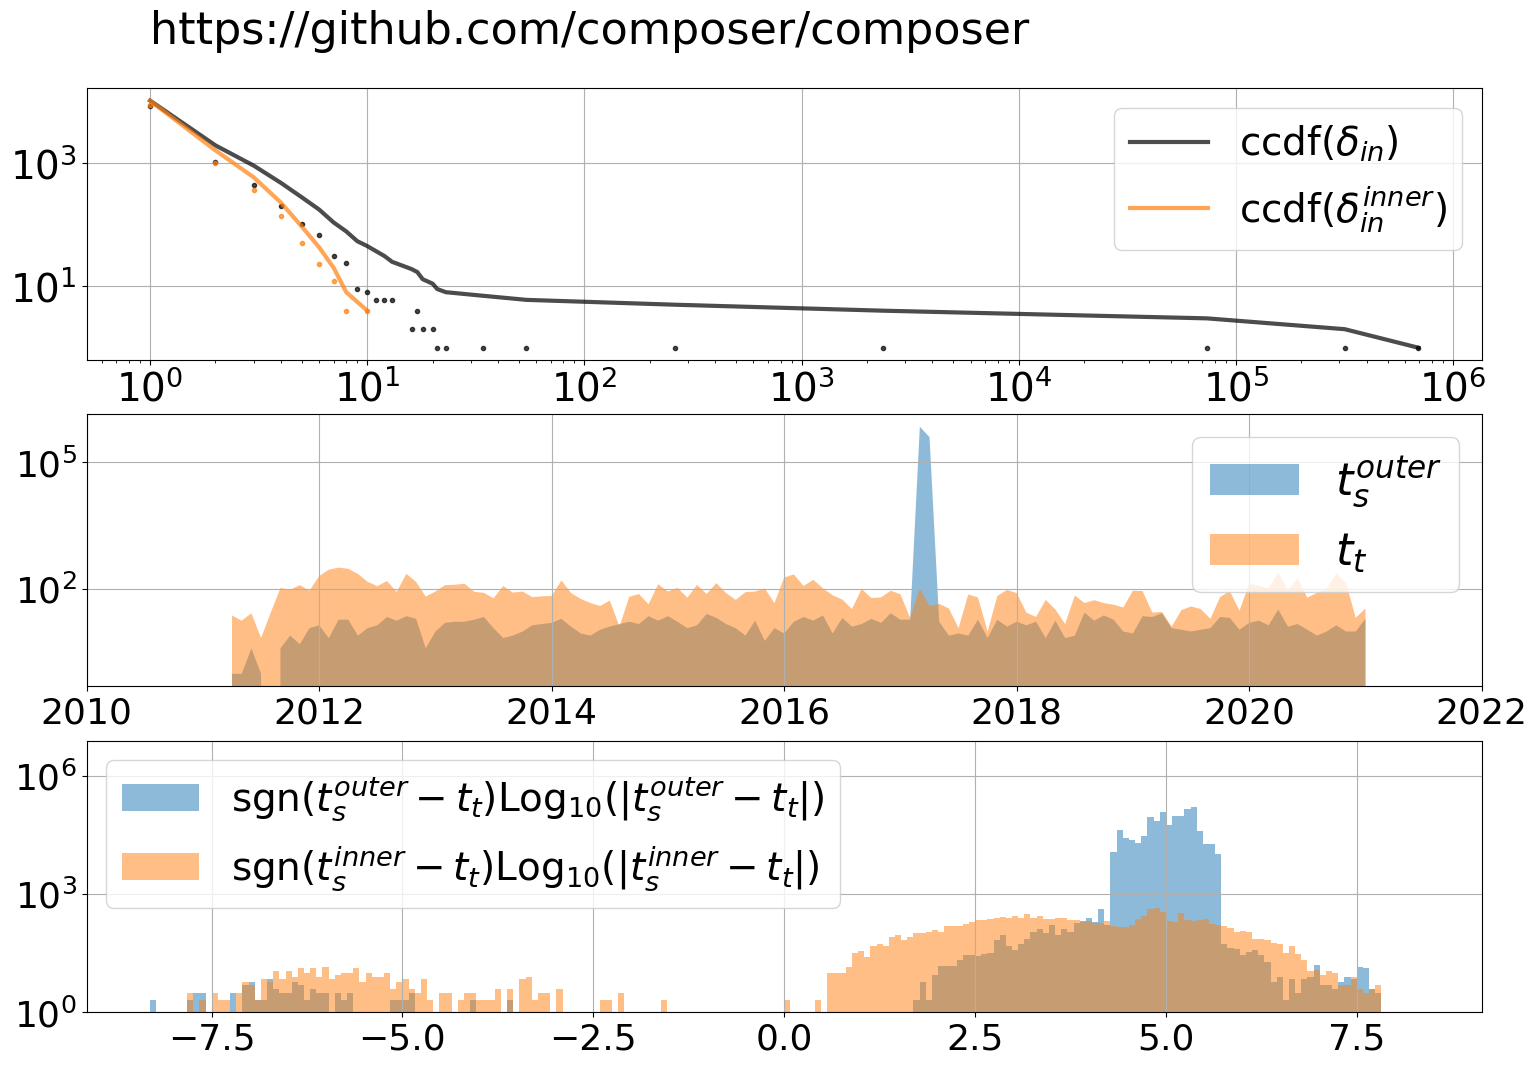

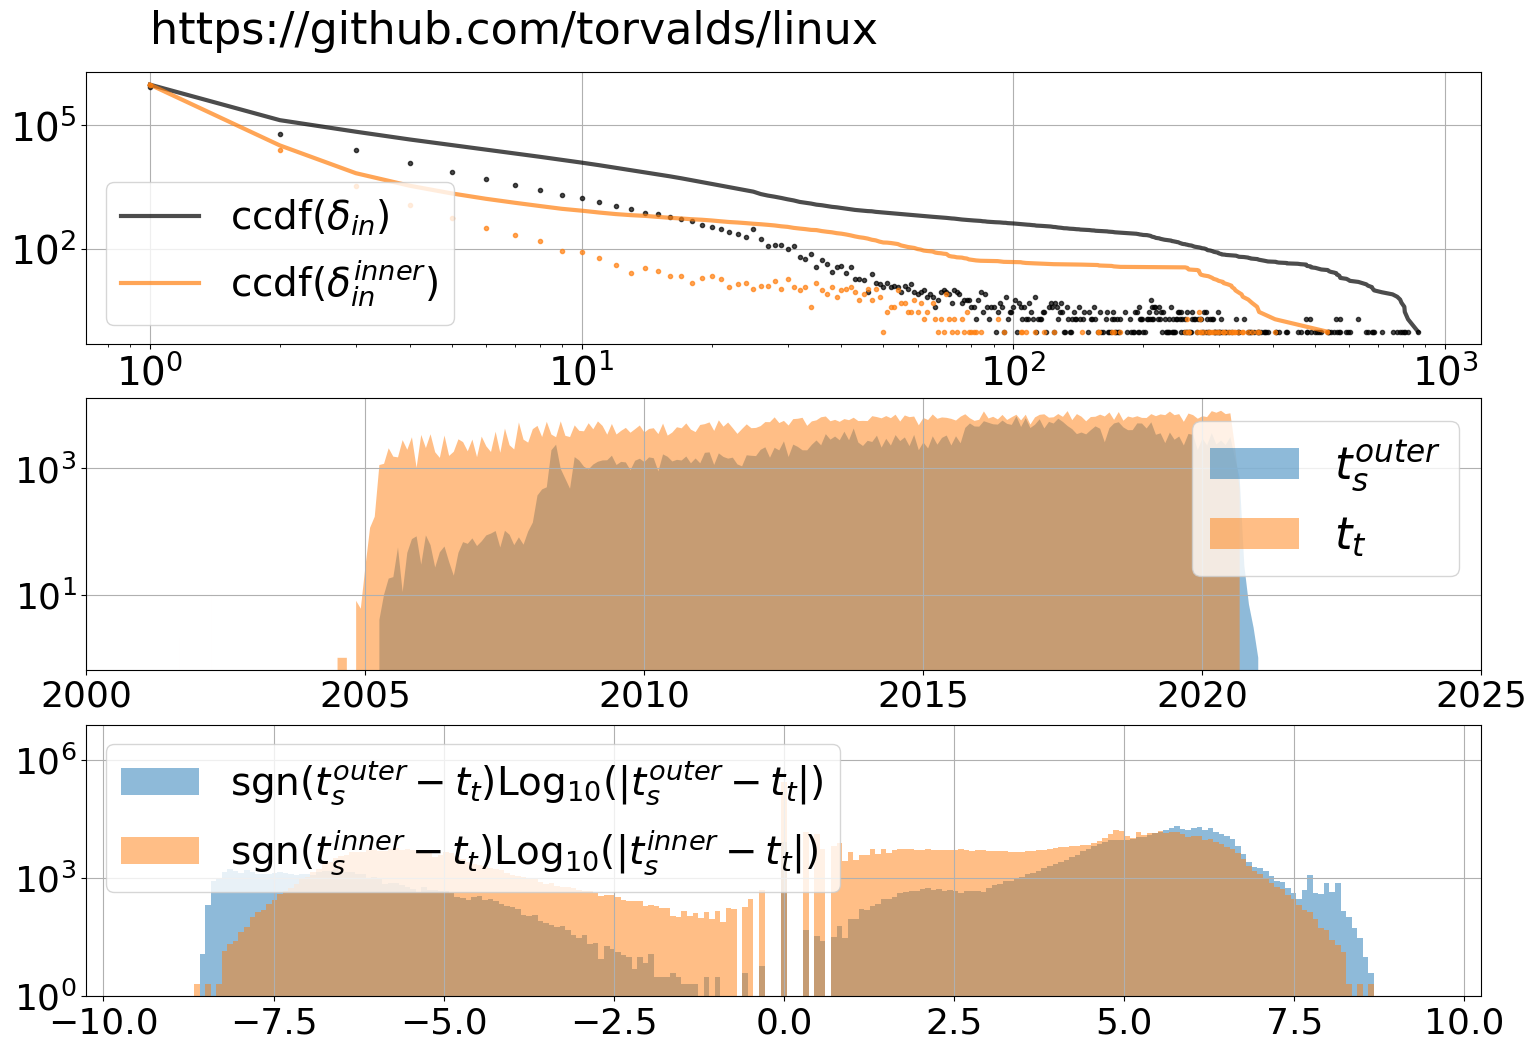

In [3]:
for name,xMinMax,yMinMax in [("composer",[None,(2010,2022),None],[None,None,(1,8e6)]),("linux",[None,(2000,2025),None],[None,None,(1,8e6)])]:
    DisplayDegreeMetricsPerOrigin(name,xMinMax,yMinMax,FlagGlobalOnly=False)

**Comment**: The representations chosen here emphasize the role of origin nodes in analyzing $RV>RV$ indegree distributions, distinguishing between inner and outer edges. For the `composer` project repository, unlike the `linux` project repository, the extreme values are primarily due to edges originating from other repositories. Although these extreme values are also temporally localized, this suggests the presence of a mechanism, referred to as *external*, as opposed to an *internal* mechanism associated with development practices within teams using distributed version control systems.

## c) Revision node partitioning algorithm(s)

The previous point highlights the importance of considering the $RV$ nodes reachable from an $O$ node. When a $RV/RL$ node is reachable from multiple $O$ nodes, the question arises as to which $O$ nodes it should be assigned to.

Ultimately, the goal is to assign all $RV$ and $RL$ nodes to a single $O$ node among those from which they are reachable.

Several strategies/partionings are possible, but this discussion is beyond the scope of this article. 
Here, we simply adopt the one used in Rousseau et al. (2019, 2020). 

This approach relies on the "size" of an $O$ node, defined as the number of $RV$ nodes existing at a given date and reachable by traversing outgoing edges from that origin.

The partitioning is easily obtained by assigning $RV$ and $RL$ nodes to the origin node from which they are reachable that has the largest "size."

**This algorithm is straightforward to implement but has the drawback of not being incremental. It depends on a global metric corresponding to an instantaneous view of the "size" of the origins, which is not guaranteed to remain invariant over time.**

As a result, there is no guarantee that the partitioning obtained for revisions in one export of the dataset at a given date will be identical to that obtained for a later export.

We refer to this as **temporal partitioning**, as it allows for defining a temporal attribute for $O$ nodes based on a function of the temporal attributes of the $RV$ nodes assigned to these origins (for instance, the earliest date associated with an $RV$ node among all $RV$ nodes assigned to a given $O$ node).

The steps to construct this partitioning are detailed below.


In [13]:
Rebuild=False
Fsave=False
Debug=True

In [27]:
if Rebuild :
    sdate1="20240310"
    origins_N_RV_RL=pickle.load(open(graphpath+"origins_Nstat_RV_RL_"+sdate1+".pkl","rb"))
    # size = (Nb of origines,4)
    # [:,0] : number of unique reachable revisions starting from a given origin
    # [:,1] : number of unique reachable releases starting from a given origin
    # [:,2] : number of unique reachable revisions starting from a given origin without following release nodes
    # [:,3] : number of unique reachable releases starting from a given origin without following release nodes (i.e. 0)
    print(type(origins_N_RV_RL),origins_N_RV_RL.shape,type(origins_N_RV_RL[0]))
    print(origins_N_RV_RL.shape)
    print(np.sum(origins_N_RV_RL,axis=0))
    OriginNRVstat=origins_N_RV_RL[:,2] 
    # only focus on the third one (i.e. nb of reachable RV nodes without following release nodes)
    if Fsave:
        pickle.dump(OriginNRVstat,open(exportpath+"origins_Size_"+sdate1+".pkl","wb"))
    #<class 'numpy.ndarray'> (139524533, 4) <class 'numpy.ndarray'>
    #(139524533, 4)
    #[146445897525    687561738 145397076485            0]

<class 'numpy.ndarray'> (139524533, 4) <class 'numpy.ndarray'>
(139524533, 4)
[146445897525    687561738 145397076485            0]


In [54]:
def CheckNstat(Oindex,nodes,edges,d=GetD()):
    # basic implementation, derived from GetNodesDescedants(index,nodes,edges)
    # excluding release node
    knownindexset=set([])
    alreadyKnown=set([])
    currentset=set([Oindex])    
    while len(currentset)!=0: 
        sonlist=[]
        for i in currentset: 
                atmp=edges[nodes[i]:nodes[i+1]]
                atmp=atmp[atmp>=d["RVindexMin"]] # only RV nodes
                sonlist+=atmp.tolist()  
        sonset=set(sonlist)
        currentset=sonset-knownindexset
        knownindexset.update(currentset)            
    return knownindexset  
if Debug:
    nodes,edges,nodesad,d,Nnodes,Nedges=LoadAllArray()
    sdate1="20240310"
    OriginNRVstat=pickle.load(open(graphpath+"origins_Size_"+sdate1+".pkl","rb"))
    print("_"*80)
    print("Integrity check")
    print("."*80)
    
    
    Ncheck=10000
    count=0
    d=GetD()
    l=np.random.randint(0,d["O"],Ncheck)
    print(f'Start stat check for {Ncheck:,} randomly chosen origin nodes')
    for Oindex in l:
        count+=1
        if count%(Ncheck//100)==0: 
            print(count//(Ncheck//100),end=" ")
        if OriginNRVstat[Oindex]!=len(CheckNstat(Oindex,nodes,edges)):
            print(Oindex,OriginNRVstat[Oindex],len(CheckNstat(Oindex,nodes,edges)))
            print("Break : At least one error")
            break
    print("/ 100% (ok if 100/100% without error message)")
    print(f'Nb of (flat) O-RV edges, without going through RL nodes {np.sum( OriginNRVstat):,} (to be compared to {len(edges):,})')
    print("_"*80)


________________________________________________________________________________
Integrity check
................................................................................
Start stat check for 10,000 randomly chosen origin nodes
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 / 100% (ok if 100/100% without error message)
Nb of (flat) O-RV edges, without going through RL nodes 145,397,076,485 (to be compared to 3,841,679,043)
________________________________________________________________________________


**Comment**: The fact that the sum of the sizes of the origins is approximately 150 billion highlights the efficiency of the representation used for this graph, which, in the analyzed version, contains fewer than 4 billion edges. A representation that directly links each origin to all $RV$ nodes reachable from this $O$ node (referred to as a "flat" representation) would be particularly resource-intensive to store.


We define the numpy array $H$ of `uint32` integers, with a dimension equal to the number of nodes, such that:

- For indices $I_O$ corresponding to $O$ nodes, $H[I_O] = \text{number of RL and RV nodes assigned to this origin}$
- For indices $I_{RL}$ and $I_{RV}$ corresponding to $RV$ and $RL$ nodes, $H[I_{RL/RV}] = I_O$, where $I_O$ is the index of the origin to which the node is assigned. Otherwise (i.e. if the $RV/RL$ node is not reachable from an $O$ node), $H[I_{RL/RV}] = 2^{32} - 1$.

The array `H` is easily constructed by first sorting $O$ nodes based on their size (in terms of the number of $RV$ nodes reachablefrom this $O$ node without passing through a $RL$ node), and then traversing the directed graph to identify the $RV$ and $RL$ nodes reachable from each $O$ nodes that have not yet been assigned to a previously processed $O$ node (i.e., a $O$ node with a greater number of reachable $RV$ nodes).


In [14]:
if Debug:
    print("(!) The 2 files (~10Go) needed to perform this integrity check is not provided")
    print("_"*80)
    print("Integrity check")
    print("."*80)
    d=GetD()
    filepath=graphpath+"nodesVisitArray_DFS__Top_Bottom_20240310.pkl"
    nodesDFS=pickle.load(open(filepath,"rb"))
    nodesDFS=np.frombuffer(nodesDFS,dtype="bool")
    H=pickle.load(open(graphpath+"H_derived_O-RVRL-O_BigO_RV_20240429.pkl","rb"))
    print("The sum H[:d['RLindexMin']] has to be equal to the number of reachable RV and RL nodes starting from the origines nodes =>",np.sum(H[:d["OindexMax"]+1])==np.sum(nodesDFS[d["RLindexMin"]:]))
    if np.sum(H[:d["OindexMax"]+1])!=np.sum(nodesDFS[d["RLindexMin"]:]):
        printprint(f'{np.sum(H[:d["OindexMax"]+1]):,}!={np.sum(nodesDFS[d["RLindexMin"]:]):,} (ok if ==)')
    print(f'# H(I_RV/RL)==0 = {np.sum(H[d["RLindexMin"]:]==0):,} (ok if =4 for this dataset)')
    print(f'# H(I_RV/RL)==2^32-1 ={np.sum(H[d["RLindexMin"]:]==np.uint32(2**32-1)):,}')
    if H[0]!=np.sum(H[d["RLindexMin"]:]==0):
        print("!!!!!! We have to fix origin node of index 0 !!!!!!")
    print("_"*80)


(!) The 2 files (~10Go) needed to perform this integrity check is not provided
________________________________________________________________________________
Integrity check
................................................................................
The sum H[:d['RLindexMin']] has to be equal to the number of reachable RV and RL nodes starting from the origines nodes => True
# H(I_RV/RL)==0 = 4 (ok if =4 for this dataset)
# H(I_RV/RL)==2^32-1 =146,860,165
________________________________________________________________________________


In [60]:
if Debug:
    # number of RV/RL assigned to O node of index 0 = 4
    # print(nodes[0],nodes[1])
    RVset=CheckNstat(0,nodes,edges,d=GetD())
    print(np.sum(edges[nodes[0]:nodes[1]]))
    ncheck=0
    for index in RVset:
        #print(index,H[index],nodes[index+1]-nodes[index])
        if H[index]==0:
            ncheck+=1
    print(f'number of RV/RL assigned to O node of index 0 = {ncheck}')


7265374540
number of RV/RL assigned to O node of index 0 = 4


In [61]:
Rebuild=True
Fsave=False
if Rebuild:
    # build file with origin size stat before and after partitionning
    # RL+RV
    tmp=H[d["RLindexMin"]:]
    tmp=tmp[tmp<=d["OindexMax"]]
    print(f'Integrity Check : {len(tmp):,} ok if = {np.sum(nodesDFS[d["RLindexMin"]:]):,}')
    # RV
    tmp=H[d["RVindexMin"]:]
    tmp=tmp[tmp<=d["OindexMax"]]
    print(f'Integrity Check : {len(tmp):,} ok if = {np.sum(nodesDFS[d["RVindexMin"]:]):,}')
    # stat RV
    tmp=np.bincount(tmp,minlength=d["O"])
    stats={}
    stats["AfterPartitioning"]={}
    
    y=np.bincount(tmp)
    x=np.arange(len(y))
    mask=y!=0
    x=x[mask]
    y=y[mask]
    ccdf=np.cumsum(y[::-1])[::-1]
    stats["AfterPartitioning"]={"x":x,"y":y,"ccdf":ccdf}
    
    stattmp=pickle.load(open(graphpath+"stat_partition_O-RV_ORI.pkl","rb"))
    stats["BeforePartitioning"]={
        "x":stattmp["avantpartition"]["x"],
        "y":stattmp["avantpartition"]["y"],
        "ccdf":np.cumsum(stattmp["avantpartition"]["y"][::-1])[::-1]
    }
    
    if Fsave:
        pickle.dump(stats,open(exportpath+"stat_partition_O-RV_ORI_FINAL.pkl","wb"))


Integrity Check : 1,937,994,142 ok if = 1,937,994,142
Integrity Check : 1,921,147,237 ok if = 1,921,147,237


## d) $O>RV$ indegree statistics before and after temporal partitionning 

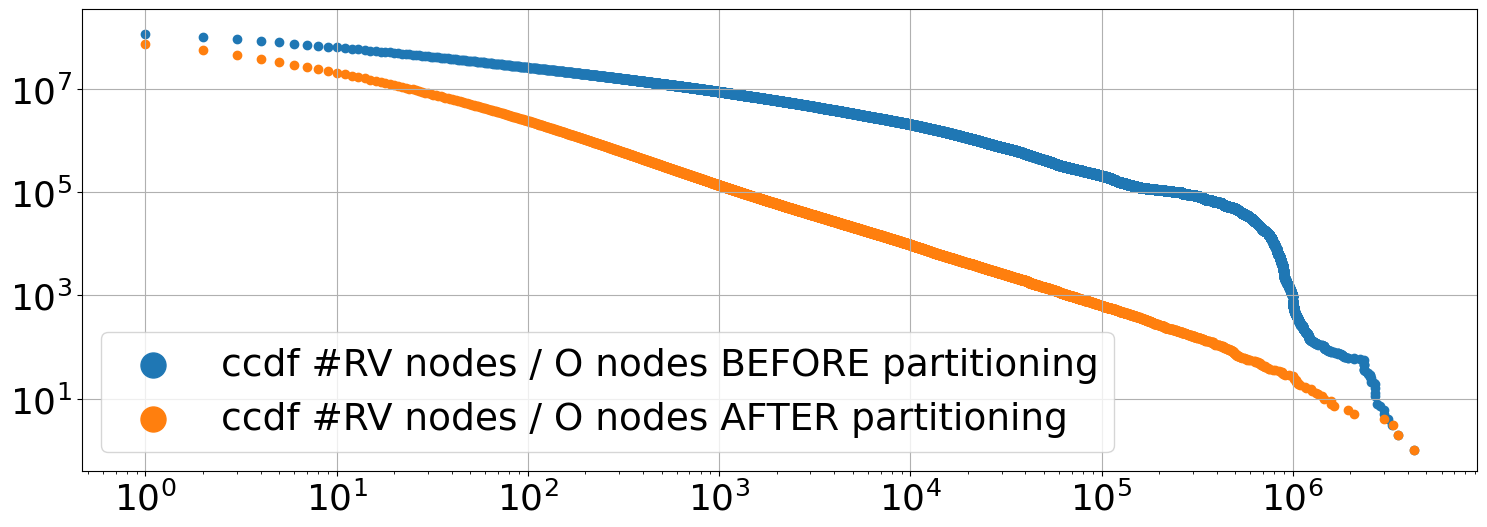

In [15]:

stat=pickle.load(open(exportpath+"stat_partition_O-RV_ORI_FINAL.pkl","rb"))

nfig=1
fontsize=FontSize[nfig]
plt.figure(figsize=(18,6))
for s,label in [("BeforePartitioning","ccdf #RV nodes / O nodes BEFORE partitioning"),("AfterPartitioning","ccdf #RV nodes / O nodes AFTER partitioning")]:
    
    x=stat[s]["x"]
    y=stat[s]["y"]
    #plt.scatter(x,y,alpha=1,label=str(i))
    plt.scatter(x,np.cumsum(y[::-1])[::-1],alpha=1,label=label)
plt.tick_params(axis='both',which='major',labelsize=fontsize-2)
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.legend(fontsize=fontsize-1,markerscale=3)
#for xpath in ['./',pathexportfigure]:
#    plt.savefig(xpath+'partitioning_O-O_ORI.png', format='png', dpi=300,bbox_inches='tight')

plt.show()


**Comment**: As expected, this figure is very similar to the one discussed in Rousseau et al. (2019, 2020), although it is based on an earlier export of the SWH dataset.

In [63]:
if Debug:
    # integrity/Quality check
    print("_"*80)
    print("Integrity check")
    print("."*80)
    filepath=graphpath+"nodesVisitArray_DFS__Top_Bottom_20240310.pkl"
    nodesDFS=pickle.load(open(filepath,"rb"))
    for s,label in [("BeforePartitioning","BEFORE partitioning"),("AfterPartitioning","AFTER partitioning")]:
        
        x=stat[s]["x"]
        y=stat[s]["y"]
        print('-'*80)
        print(label)
        print(f'# of origins nodes {np.sum(y):,} to be compared (==?) to {d["O"]:,} ')
        if s=="AfterPartitioning":
            print(f'# of deduplicated $O-RV$ path {np.sum(x*y):,} to be compared (==?) to {np.sum(nodesDFS[d["RVindexMin"]:]):,}')
        else:
            print(f'# of deduplicated $O-RV$ path {np.sum(x*y):,}')
    print("_"*80)

        

________________________________________________________________________________
Integrity check
................................................................................
--------------------------------------------------------------------------------
BEFORE partitioning
# of origins nodes 139,524,533 to be compared (==?) to 139,524,533 
# of deduplicated $O-RV$ path 145,397,076,485
--------------------------------------------------------------------------------
AFTER partitioning
# of origins nodes 139,524,533 to be compared (==?) to 139,524,533 
# of deduplicated $O-RV$ path 1,921,147,237 to be compared (==?) to 1,921,147,237
________________________________________________________________________________
